# build a basic chatbot with langraph(graph API)

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END 
from langgraph.graph.message import add_messages # reducers


In [2]:
class State(TypedDict): # return type is dictionary
    # messages have the type "list". the add_messages function
    # in the annotation defines how this state key should be updated 
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list,add_messages]
graph_builder=StateGraph(State)

In [3]:
graph_builder

In [4]:
import os 
from dotenv import load_dotenv
load_dotenv()

True

In [5]:
# define LLM's
from langchain_groq import ChatGroq
from langchain_openai import AzureChatOpenAI

llm_open_ai=AzureChatOpenAI(
    azure_deployment='gpt-4o',
    api_key=os.getenv('AZURE_OPENAI_GPT_4O_API_KEY'),
    azure_endpoint=os.getenv('AZURE_OPENAI_GPT_4O_API_ENDPOINT'),
    api_version=os.getenv('AZURE_OPENAI_GPT_4O_API_VERSION')
)

llm_groq=ChatGroq(model='deepseek-r1-distill-llama-70b',api_key=os.getenv('GROQ_API'))


# create a chatbot node

In [6]:
def chatbot(state:State):
    return {'messages':[llm_open_ai.invoke(state['messages'])]}


In [7]:
graph_builder=StateGraph(State)
## Adding node
graph_builder.add_node('llmchatbot',chatbot)
graph_builder.add_edge(START,'llmchatbot')
graph_builder.add_edge('llmchatbot',END)

## compile the graph 
graph=graph_builder.compile()


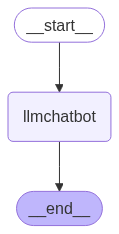

In [8]:
## Visualize the graph 
from IPython.display import Image,display 

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass 

In [9]:
response=graph.invoke({'messages':'what is life?'})

In [10]:
response['messages'][-1].content

'The question "What is life?" is one of the most profound and enduring inquiries in human thought, spanning philosophy, science, religion, and art. The answer depends on the context in which it\'s asked—scientific, existential, spiritual, or personal.\n\n### Scientific Perspective:\nFrom a biological and scientific standpoint, life is often defined by specific characteristics that distinguish living organisms from non-living matter. These characteristics include:\n\n1. **Cellular Organization:** Living things are made up of one or more cells.\n2. **Metabolism:** They use energy and perform biochemical reactions to sustain themselves.\n3. **Growth and Development:** Organisms grow and follow specific life cycles.\n4. **Homeostasis:** They maintain internal stability despite external changes.\n5. **Reproduction:** Life produces offspring to pass on genetic information.\n6. **Adaptation and Evolution:** Species evolve over time to better survive in their environment.\n7. **Response to Sti

In [11]:
for event in graph.stream({'messages':'Hi How are you?'}):
    for val in event.values():
        print(val['messages'][-1].content)

Hello! I'm just a bundle of virtual energy, so I'm always good—thank you for asking! 😊 How about you? How's your day going?


In [12]:
from langchain_core.messages import HumanMessage
response = graph.invoke({"messages": [HumanMessage(content="Hi")]})
response = graph.invoke({"messages": [HumanMessage(content="sup")]})
for msg in response['messages']:
    print(f"{msg.type.upper()}: {msg.content}")


HUMAN: sup
AI: Hey there! What's up? How can I assist you today? 😊


# chatbot with tools 

In [13]:
from langchain_tavily import TavilySearch

tool=TavilySearch(max_results=2)
tool.invoke('what is langgraph')

{'query': 'what is langgraph',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'What is LangGraph? - IBM',
   'url': 'https://www.ibm.com/think/topics/langgraph',
   'content': 'LangGraph, created by LangChain, is an open source AI agent framework designed to build, deploy and manage complex generative AI agent workflows. At its core, LangGraph uses the power of graph-based architectures to model and manage the intricate relationships between various components of an AI agent workflow. LangGraph illuminates the processes within an AI workflow, allowing full transparency of the agent’s state. By combining these technologies with a set of APIs and tools, LangGraph provides users with a versatile platform for developing AI solutions and workflows including chatbots, state graphs and other agent-based systems. Nodes: In LangGraph, nodes represent individual components or agents within an AI workflow. LangGraph uses enhanced decision-making by modeling c

In [14]:
## Custom function 
def multiply(a:int,b:int)-> int:
    """ 
    Multiply a and b
    Agrs:
        a (int): first int
        b (int): second int 
    Returns:
        int: output int     
    """
    return a*b


In [15]:
tools=[tool,multiply]

In [16]:
llm_with_tools=llm_open_ai.bind_tools(tools)
llm_with_tools

RunnableBinding(bound=AzureChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x000002C4C2E33E90>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x000002C4C32E23F0>, root_client=<openai.lib.azure.AzureOpenAI object at 0x000002C4C2DCEBD0>, root_async_client=<openai.lib.azure.AsyncAzureOpenAI object at 0x000002C4C2E33F80>, model_kwargs={}, openai_api_key=SecretStr('**********'), disabled_params={'parallel_tool_calls': None}, azure_endpoint='https://llmops-amruth.openai.azure.com/', deployment_name='gpt-4o', openai_api_version='2024-12-01-preview', openai_api_type='azure'), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range fil

In [17]:
## state graph 
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# node definition 
def tool_calling_llm(state:State):
    return {'messages':[llm_with_tools.invoke(state['messages'])]}

## create a graph 
builder=StateGraph(State)
builder.add_node('tool_calling_llm',tool_calling_llm)
builder.add_node('tools',ToolNode(tools))
builder.add_edge(START,'tool_calling_llm')
builder.add_conditional_edges(
    'tool_calling_llm',tools_condition
    # if the latest message (result) from assistant is a tool call -> tools_confition routes to tools 
    # if the latest message (result) from assistant is not a tool call -> tools_confition routes to END 
)
builder.add_edge('tools',END)
graph=builder.compile()

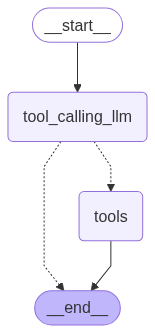

In [18]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
response=graph.invoke({"messages":'what is the resent AI news?'})
response

{'messages': [HumanMessage(content='what is the resent AI news?', additional_kwargs={}, response_metadata={}, id='4aa785d2-a17f-4eea-87f7-8b8d16a01cce'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_9qOeEfYZo8213NSZ6e6iK4Ib', 'function': {'arguments': '{"query":"recent AI news","search_depth":"advanced","time_range":"week","topic":"news"}', 'name': 'tavily_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 33, 'prompt_tokens': 823, 'total_tokens': 856, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-BnwHTbuuQ4dNEXJVzNGT32PqiB4LB', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity':

In [20]:
response['messages'][-1].content

'{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.newsweek.com/nw-ai/ai-impact-awards-2025-science-engineering-2084754", "title": "AI Impact Awards 2025: The Changing Human Role in Science and Engineering - Newsweek", "score": 0.7251239, "published_date": "Wed, 25 Jun 2025 10:02:01 GMT", "content": "Newsweek _\\\\_will continue the conversation on meaningful AI innovations at our AI Impact Summit from June 23 to 25 in Sonoma, California. Click here to follow along on the live blog.\\\\__\\n\\nRequest Reprint & LicensingSubmit CorrectionView Editorial Guidelines\\n\\nSHARE:xfacebooklinkedinredditemailwhatsappCopy & Share\\n\\n✓ Link copied to clipboard!\\n\\nThe Latest in AI\\n----------------\\n\\nNEWSWEEK.AI\\n\\n06.09.25\\n\\n### Generative AI\'s Mission to Explore Strange New Worlds [...] ### AI Will Connect Mercedes-Benz Places Residents to the World\\n\\nThe new Miami condo complex will have state-of-the-art te

In [21]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

what is the resent AI news?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_9qOeEfYZo8213NSZ6e6iK4Ib)
 Call ID: call_9qOeEfYZo8213NSZ6e6iK4Ib
  Args:
    query: recent AI news
    search_depth: advanced
    time_range: week
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.newsweek.com/nw-ai/ai-impact-awards-2025-science-engineering-2084754", "title": "AI Impact Awards 2025: The Changing Human Role in Science and Engineering - Newsweek", "score": 0.7251239, "published_date": "Wed, 25 Jun 2025 10:02:01 GMT", "content": "Newsweek _\\_will continue the conversation on meaningful AI innovations at our AI Impact Summit from June 23 to 25 in Sonoma, California.

In [22]:
response=graph.invoke({"messages":'2*3?'})
response

{'messages': [HumanMessage(content='2*3?', additional_kwargs={}, response_metadata={}, id='f18c0f2a-2c86-4232-a19f-79ec26c44d58'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_yF4VRZe3fBVMon6Nrfh5SPU5', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 820, 'total_tokens': 838, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-BnwHXCilJkZS1Q6FELwegdQZuKDRT', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'sever

In [23]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

2*3?
================================== Ai Message ==================================
Tool Calls:
  multiply (call_yF4VRZe3fBVMon6Nrfh5SPU5)
 Call ID: call_yF4VRZe3fBVMon6Nrfh5SPU5
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6


In [24]:
response=graph.invoke({"messages":'2*3*10?'})
response

{'messages': [HumanMessage(content='2*3*10?', additional_kwargs={}, response_metadata={}, id='df02d7b5-64bc-445f-bc6b-5a6ffcbd367b'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_z78D1VzQoclWtxJbcCyDdMqk', 'function': {'arguments': '{"a": 2, "b": 3}', 'name': 'multiply'}, 'type': 'function'}, {'id': 'call_VMiwANVqfVJyv5xO1cjTal3T', 'function': {'arguments': '{"a": 6, "b": 10}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 822, 'total_tokens': 873, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-BnwHXqDjiFKD6uTXpE5cX6pWxBj5P', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate'

In [25]:
response=graph.invoke({"messages":'what is the latest AI news and how is NVIDIA stock?'})
response

{'messages': [HumanMessage(content='what is the latest AI news and how is NVIDIA stock?', additional_kwargs={}, response_metadata={}, id='380fda10-9edc-4834-94a1-0d4df99f22f6'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_6udR7vCKDEK9QXeWykeO0oG7', 'function': {'arguments': '{"query": "latest AI news", "time_range": "day", "topic": "news"}', 'name': 'tavily_search'}, 'type': 'function'}, {'id': 'call_I3u6e8hphWvVGMchKiiDT2qY', 'function': {'arguments': '{"query": "NVIDIA stock", "topic": "finance"}', 'name': 'tavily_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 66, 'prompt_tokens': 828, 'total_tokens': 894, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-Bn

## react agent architecture 

In [26]:
## state graph 
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# node definition 
def tool_calling_llm(state:State):
    return {'messages':[llm_with_tools.invoke(state['messages'])]}

## create a graph 
builder=StateGraph(State)
builder.add_node('tool_calling_llm',tool_calling_llm)
builder.add_node('tools',ToolNode(tools))
builder.add_edge(START,'tool_calling_llm')
builder.add_conditional_edges(
    'tool_calling_llm',tools_condition
    # if the latest message (result) from assistant is a tool call -> tools_confition routes to tools 
    # if the latest message (result) from assistant is not a tool call -> tools_confition routes to END 
)
builder.add_edge('tools','tool_calling_llm')
graph=builder.compile()

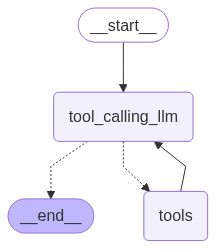

In [27]:
from IPython.display import Image,display 

from IPython.display import Image, display 
display(Image(graph.get_graph().draw_mermaid_png()))

In [28]:
response=graph.invoke({'messages':'give me the resent AI news and what is 3*10*12'})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

give me the resent AI news and what is 3*10*12
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_6bxWsC6iMiwi8i1X8EXbTfj1)
 Call ID: call_6bxWsC6iMiwi8i1X8EXbTfj1
  Args:
    query: recent AI news
    search_depth: advanced
    time_range: week
    topic: news
  multiply (call_02FiIGaAYGT0KtsVkEhg4fd2)
 Call ID: call_02FiIGaAYGT0KtsVkEhg4fd2
  Args:
    a: 3
    b: 10
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.newsweek.com/nw-ai/ai-impact-awards-2025-science-engineering-2084754", "title": "AI Impact Awards 2025: The Changing Human Role in Science and Engineering - Newsweek", "score": 0.7251239, "published_date": "Wed, 25 Jun 2025 10:02:01 GMT", "content": "Newsweek 

In [29]:
response=graph.invoke({'messages':'Hello whats my name?'})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello whats my name?
================================== Ai Message ==================================

You haven't shared your name with me yet! What's your name?


# Adding memory in Agentic Graph

In [30]:
# state class 
from langgraph.prebuilt import ToolNode 

class State(TypedDict):
    messages:Annotated[list,add_messages]
builder=StateGraph(State)

# add chatbot node
def chatbot(state:State):
    return {'messages':[llm_open_ai.invoke(state['messages'])]}

tool=TavilySearch(max_results=2)
tools=[tool,multiply]

llm_with_tools=llm_open_ai.bind_tools(tools)



In [31]:
# stategraph 
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory=MemorySaver()

## Node definition
def tool_calling_llm(state:State):
    return {'messages':[llm_with_tools.invoke(state['messages'])]}

## create a graph 
builder1=StateGraph(State)
builder1.add_node('tool_calling_llm',tool_calling_llm)
builder1.add_node('tools',ToolNode(tools))
builder1.add_edge(START,'tool_calling_llm')
builder1.add_conditional_edges('tool_calling_llm',tools_condition)
builder1.add_edge('tools','tool_calling_llm')

# add memory and compile 
graph=builder1.compile(checkpointer=memory)


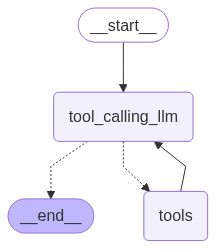

In [32]:
from IPython.display import Image,display
display(Image(graph.get_graph().draw_mermaid_png()))

In [33]:
# creating thread variable 
config={'configurable':{'thread_id':'1'}}
response=graph.invoke({'messages':'Hi my name is amruth'},config=config)

response

{'messages': [HumanMessage(content='Hi my name is amruth', additional_kwargs={}, response_metadata={}, id='b83e85f4-c57b-4084-8cb1-35a033ea71dc'),
  AIMessage(content='Hello, Amruth! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 823, 'total_tokens': 838, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-BnwHjRmr9pO7hSfvEGAHfRVMtm7fY', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'fil

In [34]:
response=graph.invoke({'messages':'what is 3 multiplied by 10 also what is the latest news on USA and IRAN?'},config=config)
response

{'messages': [HumanMessage(content='Hi my name is amruth', additional_kwargs={}, response_metadata={}, id='b83e85f4-c57b-4084-8cb1-35a033ea71dc'),
  AIMessage(content='Hello, Amruth! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 823, 'total_tokens': 838, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-BnwHjRmr9pO7hSfvEGAHfRVMtm7fY', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'fil

In [35]:
response=graph.invoke({'messages':'what is my name?'},config=config)
response

{'messages': [HumanMessage(content='Hi my name is amruth', additional_kwargs={}, response_metadata={}, id='b83e85f4-c57b-4084-8cb1-35a033ea71dc'),
  AIMessage(content='Hello, Amruth! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 823, 'total_tokens': 838, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-BnwHjRmr9pO7hSfvEGAHfRVMtm7fY', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'fil

In [36]:
response=graph.invoke({'messages':'what is my name?'},config=config)
response

{'messages': [HumanMessage(content='Hi my name is amruth', additional_kwargs={}, response_metadata={}, id='b83e85f4-c57b-4084-8cb1-35a033ea71dc'),
  AIMessage(content='Hello, Amruth! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 823, 'total_tokens': 838, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-BnwHjRmr9pO7hSfvEGAHfRVMtm7fY', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'fil

# Streaming

In [37]:
from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()

In [38]:
def superbot(state:State):
    return {'messages':[llm_open_ai.invoke(state['messages'])]}

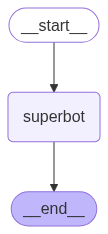

In [39]:
graph=StateGraph(State)

graph.add_node('superbot',superbot)

graph.add_edge(START,'superbot')
graph.add_edge('superbot',END)

graph_builder=graph.compile(checkpointer=memory)

## display 
from IPython.display import Image, display
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [40]:
# Invoking 
config={'configurable':{'thread_id':'1'}}
graph_builder.invoke({'messages':'Hi, my name is Amruth and i like swimming'},config)

{'messages': [HumanMessage(content='Hi, my name is Amruth and i like swimming', additional_kwargs={}, response_metadata={}, id='72e1ef35-7c17-4891-969d-c698e5233b4a'),
  AIMessage(content="Hi Amruth! It's great to meet you. That's awesome that you like swimming—it's such a fun and healthy activity! Do you swim just for fun, or are you training or competing? What's your favorite stroke? 😊🏊\u200d♂️", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 52, 'prompt_tokens': 19, 'total_tokens': 71, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-BnwHqdKBTL2SUY52drZmw48dm7XD9', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity

In [41]:
# only thr last messages 
config={'configurable':{'thread_id':'3'}}
for chunk in graph_builder.stream({'messages':'Hi, My name is Amruth and i like swimming'},config,stream_mode='updates'):
    print(chunk)

{'superbot': {'messages': [AIMessage(content="Hi Amruth! It's great to meet you. That's awesome that you enjoy swimming! It's such a fantastic way to stay active, relax, and have fun. Do you like swimming for fitness, as a sport, or just for fun? What's your favorite stroke? 🏊\u200d♂️", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 61, 'prompt_tokens': 19, 'total_tokens': 80, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-BnwHrgHE8wG7wGfwuPVrJ9z5J06QS', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'saf

In [42]:
# the messages are appended to the thead
config={'configurable':{'thread_id':'3'}}
for chunk in graph_builder.stream({'messages':'Hi, My name is Amruth and i like swimming'},config,stream_mode='values'):
    print(chunk)

{'messages': [HumanMessage(content='Hi, My name is Amruth and i like swimming', additional_kwargs={}, response_metadata={}, id='c511cc89-30e5-4312-a4c6-37be066ac97a'), AIMessage(content="Hi Amruth! It's great to meet you. That's awesome that you enjoy swimming! It's such a fantastic way to stay active, relax, and have fun. Do you like swimming for fitness, as a sport, or just for fun? What's your favorite stroke? 🏊\u200d♂️", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 61, 'prompt_tokens': 19, 'total_tokens': 80, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-BnwHrgHE8wG7wGfwuPVrJ9z5J06QS', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'

In [43]:
config={'configurable':{'thread_id':'4'}}
for chunk in graph_builder.stream({'messages':'Hi, My name is Amruth and i like swimming'},config,stream_mode='updates'):
    print(chunk)

{'superbot': {'messages': [AIMessage(content="Hi Amruth! It's great to meet you! Swimming is such an awesome activity—so refreshing and a fantastic way to stay fit. Do you swim for fun, or are you into competitive swimming as well? What's your favorite stroke? 🏊\u200d♂️", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 55, 'prompt_tokens': 19, 'total_tokens': 74, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-BnwHuOXqrX9E1zkjjGKpZjgPp1gOI', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': 

In [44]:
config={'configurable':{'thread_id':'4'}}
for chunk in graph_builder.stream({'messages':'what is my favourite sport?'},config,stream_mode='updates'):
    print(chunk)

{'superbot': {'messages': [AIMessage(content="Well, since you mentioned you like swimming, I think it might be your favorite sport! 🏊\u200d♂️ But if there's another sport you love just as much (or even more), feel free to share—I’d love to hear about it! 😊", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 53, 'prompt_tokens': 87, 'total_tokens': 140, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-BnwHvVeFVty69ADryO8LHlhWp3y6S', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': 

In [45]:
config={'configurable':{'thread_id':'5'}}
for chunk in graph_builder.stream({'messages':'Hi, My name is Amruth and i like swimming and football'},config,stream_mode='values'):
    print(chunk)

{'messages': [HumanMessage(content='Hi, My name is Amruth and i like swimming and football', additional_kwargs={}, response_metadata={}, id='65ab4ce9-0416-4d59-a28a-bbaa788d0408')]}
{'messages': [HumanMessage(content='Hi, My name is Amruth and i like swimming and football', additional_kwargs={}, response_metadata={}, id='65ab4ce9-0416-4d59-a28a-bbaa788d0408'), AIMessage(content="Hi Amruth! It's nice to meet you. Swimming and football are both fantastic activities. They keep you fit and are a lot of fun too! Do you have a favorite swimming stroke or football team you support? 😊", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 46, 'prompt_tokens': 21, 'total_tokens': 67, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_ee1d74bde

In [46]:
for chunk in graph_builder.stream({'messages':'which sport is better for cardio?'},config,stream_mode='values'):
    print(chunk)

{'messages': [HumanMessage(content='Hi, My name is Amruth and i like swimming and football', additional_kwargs={}, response_metadata={}, id='65ab4ce9-0416-4d59-a28a-bbaa788d0408'), AIMessage(content="Hi Amruth! It's nice to meet you. Swimming and football are both fantastic activities. They keep you fit and are a lot of fun too! Do you have a favorite swimming stroke or football team you support? 😊", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 46, 'prompt_tokens': 21, 'total_tokens': 67, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-BnwHwPFkVnGjtHdiXwDr1ncMMNVou', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severi

In [47]:
for chunk in graph_builder.stream({'messages':'when is the best time to swim?'},config,stream_mode='values'):
    print(chunk)

{'messages': [HumanMessage(content='Hi, My name is Amruth and i like swimming and football', additional_kwargs={}, response_metadata={}, id='65ab4ce9-0416-4d59-a28a-bbaa788d0408'), AIMessage(content="Hi Amruth! It's nice to meet you. Swimming and football are both fantastic activities. They keep you fit and are a lot of fun too! Do you have a favorite swimming stroke or football team you support? 😊", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 46, 'prompt_tokens': 21, 'total_tokens': 67, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-BnwHwPFkVnGjtHdiXwDr1ncMMNVou', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severi

In [48]:
# A stream

# Human in the loop

In [49]:
from typing import Annotated
from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.types import Command, interrupt

class State(TypedDict):
    messages:Annotated[list,add_messages]

graph_builder=StateGraph(State)

@tool
def human_assistance(query:str)->str:
    """ 
    Request assistance from a human
    """
    human_response=interrupt({'query':query})
    return human_response['data']

tool=TavilySearch(max_results=2)
tools=[tool,human_assistance]
llm_with_tools=llm_open_ai.bind_tools(tools)

def chatbot(state:State):
    message=llm_with_tools.invoke(state['messages'])
    # Because wwe will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any 
    # tool invocations when we resume 
    return {'messages':[message]}

graph_builder.add_node('chatbot',chatbot)
tool_node=ToolNode(tools=tools)
graph_builder.add_node('tools',tool_node)
graph_builder.add_conditional_edges(
    'chatbot',
    tools_condition
)

graph_builder.add_edge('tools','chatbot')
graph_builder.add_edge(START,'chatbot')

In [50]:
memory=MemorySaver()
graph=graph_builder.compile(checkpointer=memory)


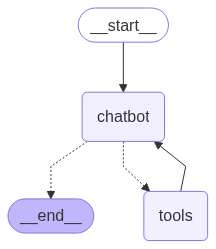

In [51]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass 

In [56]:
user_input='I need some expert guidance and assisstance for building an AI agent. Could you request assisstance for me?'
config={'configurable':{'thread_id':'2'}}

events=graph.stream({'messages':user_input},config=config,stream_mode='values',)

for event in events:
    if "messages" in event:
        event['messages'][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance and assisstance for building an AI agent. Could you request assisstance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_9x0QUuWOXyExLNwT293GVA7n)
 Call ID: call_9x0QUuWOXyExLNwT293GVA7n
  Args:
    query: User requires expert guidance for building an AI agent. Initiate assistance process and connect them with an expert.


In [57]:
human_response=("we, the expertes are here to help, we'd recommend you check out langgraph to build your agent."
        "Its much more reliable and extensible than simple autonomous agents")

human_command=Command(resume={'data':human_response})

events=graph.stream(human_command,config=config,stream_mode='values',)

for event in events:
    if "messages" in event:
        event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_9x0QUuWOXyExLNwT293GVA7n)
 Call ID: call_9x0QUuWOXyExLNwT293GVA7n
  Args:
    query: User requires expert guidance for building an AI agent. Initiate assistance process and connect them with an expert.
================================= Tool Message =================================
Name: human_assistance

we, the expertes are here to help, we'd recommend you check out langgraph to build your agent.Its much more reliable and extensible than simple autonomous agents
================================== Ai Message ==================================

The experts suggest using Langgraph for building your AI agent. It is considered to be very reliable and extensible compared to simple autonomous agents. Would you like further help in setting this up or exploring Langgraph's capabilities?


In [58]:
user_input='yes proceed'
config={'configurable':{'thread_id':'2'}}

events=graph.stream({'messages':user_input},config=config,stream_mode='values',)

for event in events:
    if "messages" in event:
        event['messages'][-1].pretty_print()

================================ Human Message =================================

yes proceed
================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_XUu3f3puOREFD3oKqFThksVb)
 Call ID: call_XUu3f3puOREFD3oKqFThksVb
  Args:
    query: User wants to proceed with exploring and setting up Langgraph for building their AI agent. Could you provide more guidance or next steps for them?


In [59]:
human_response=("search for langgraphs for building agents")

human_command=Command(resume={'data':human_response})

events=graph.stream(human_command,config=config,stream_mode='values',)

for event in events:
    if "messages" in event:
        event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_XUu3f3puOREFD3oKqFThksVb)
 Call ID: call_XUu3f3puOREFD3oKqFThksVb
  Args:
    query: User wants to proceed with exploring and setting up Langgraph for building their AI agent. Could you provide more guidance or next steps for them?
================================= Tool Message =================================
Name: human_assistance

search for langgraphs for building agents
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_Y9WlgMdf6eBenltGS7uHKOnx)
 Call ID: call_Y9WlgMdf6eBenltGS7uHKOnx
  Args:
    query: Langgraph for building AI agents
    search_depth: advanced
================================= Tool Message =================================
Name: tavily_search

{"query": "Langgraph for building AI agents", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://medium.